# Network quality

This workbook is focused around the task:

- Modelling Oslo’s Public Transit Network as a Complex Network  
- Inspecting the GTFS-derived graph for logical and structural data issues  
- Validating that the network is suitable for flow, robustness, and capacity analysis  

# Step 0 – Imports and data loading

In [1]:
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["figure.dpi"] = 140


CWD = Path.cwd()
print("CWD:", CWD)

PROJECT_ROOT = CWD.parents[1]
print("PROJECT_ROOT:", PROJECT_ROOT)

# GTFS extraction output directory
OUT_DIR = PROJECT_ROOT / "Extraction" / "out"

nodes_path = OUT_DIR / "nodes_GTFS_OSLO.csv"
edges_path = OUT_DIR / "edges_GTFS_OSLO.csv"

print("Nodes path:", nodes_path, "| exists:", nodes_path.exists())
print("Edges path:", edges_path, "| exists:", edges_path.exists())

# Load CSVs

nodes = pd.read_csv(nodes_path)
edges = pd.read_csv(edges_path)

display(nodes.head())
display(edges.head())

print("Nodes shape:", nodes.shape)
print("Edges shape:", edges.shape)


CWD: C:\Users\Simen\ACIT4620_Exam_Project_Code\Modeling\Simen
PROJECT_ROOT: C:\Users\Simen\ACIT4620_Exam_Project_Code
Nodes path: C:\Users\Simen\ACIT4620_Exam_Project_Code\Extraction\out\nodes_GTFS_OSLO.csv | exists: True
Edges path: C:\Users\Simen\ACIT4620_Exam_Project_Code\Extraction\out\edges_GTFS_OSLO.csv | exists: True


,id,stopPlaceId,name,lat,lon,modes,stopType
0,NSR:Quay:99688,NSR:Quay:99688,Vækerø,59.915650,10.651833,"bus,coach service",multimodal
1,NSR:Quay:11880,NSR:Quay:11880,Maritim,59.918496,10.667065,"bus,coach service",multimodal
2,NSR:Quay:11829,NSR:Quay:11829,Sjølyst,59.920456,10.676683,"bus,coach service",multimodal
3,NSR:Quay:7700,NSR:Quay:7700,Vika atrium,59.910762,10.722139,"bus,coach service",multimodal
4,NSR:Quay:11969,NSR:Quay:11969,Oslo bussterminal,59.911940,10.756710,bus,bus


,from,to,lineId,lineCode,mode,authority,travelTimeSec,tripsInFeed
0,NSR:Quay:99688,NSR:Quay:11880,BRA:Line:4_6169,169,bus,Brakar,60.0,7
1,NSR:Quay:11880,NSR:Quay:11829,BRA:Line:4_6169,169,bus,Brakar,60.0,7
2,NSR:Quay:11829,NSR:Quay:7700,BRA:Line:4_6169,169,bus,Brakar,120.0,7
3,NSR:Quay:7700,NSR:Quay:11969,BRA:Line:4_6169,169,bus,Brakar,660.0,7
4,NSR:Quay:12002,NSR:Quay:7699,BRA:Line:4_6169,169,bus,Brakar,660.0,7


Nodes shape: (1941, 7)
Edges shape: (4825, 8)


# Step 1 – Building the NetworkX graph

- Use the GTFS nodes as NetworkX nodes  
- Add latitude, longitude, name, and stop type as attributes  
- Add directed edges for each GTFS connection (from → to)  
- Store travel time, mode, line, and operator on edges  


In [2]:
# Column names
NODE_ID_COL = "id"
NODE_LAT_COL = "lat"
NODE_LON_COL = "lon"
NODE_NAME_COL = "name"

EDGE_FROM_COL = "from"
EDGE_TO_COL   = "to"
EDGE_TIME_COL = "travelTimeSec"

# Create directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in nodes.iterrows():
    G.add_node(
        row[NODE_ID_COL],
        name=row[NODE_NAME_COL],
        lat=row[NODE_LAT_COL],
        lon=row[NODE_LON_COL],
        stopType=row["stopType"],
        modes=row["modes"],
    )

# Add edges with attributes
for _, row in edges.iterrows():
    G.add_edge(
        row[EDGE_FROM_COL],
        row[EDGE_TO_COL],
        travelTime=row[EDGE_TIME_COL],
        mode=row["mode"],
        line=row["lineId"],
        authority=row["authority"],
        tripsInFeed=row["tripsInFeed"],
    )

print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())


Graph nodes: 1941
Graph edges: 2430


# Step 2 – Logical data quality checks

These checks identify issues in the GTFS data:

- **Isolated nodes:** stops with no connections  
- **Orphan edges:** edges referring to non-existent stops  
- **Invalid travel times:** missing, zero, or negative durations  


In [3]:
# Isolated nodes (no edges at all)
isolated_nodes = list(nx.isolates(G.to_undirected()))
print("Isolated nodes in graph:", len(isolated_nodes))

# Orphan edges (from/to not present in nodes table)
node_ids = set(nodes[NODE_ID_COL])
orphan_edges = edges[
    ~edges[EDGE_FROM_COL].isin(node_ids) |
    ~edges[EDGE_TO_COL].isin(node_ids)
]
print("Orphan edges in CSV:", len(orphan_edges))

if len(orphan_edges) > 0:
    display(orphan_edges.head())

# Edges with missing, zero or negative travel times
bad_time = edges[
    edges[EDGE_TIME_COL].isna() |
    (edges[EDGE_TIME_COL] <= 0)
]
print("Edges with non-positive or missing travelTimeSec:", len(bad_time))

if len(bad_time) > 0:
    display(bad_time.head())


Isolated nodes in graph: 0
Orphan edges in CSV: 0
Edges with non-positive or missing travelTimeSec: 150


,from,to,lineId,lineCode,mode,authority,travelTimeSec,tripsInFeed
49,NSR:Quay:10656,NSR:Quay:10668,INN:Line:126,126,bus,Innlandstrafikk,NaN,6
56,NSR:Quay:11448,NSR:Quay:11456,INN:Line:126,126,bus,Innlandstrafikk,NaN,6
62,NSR:Quay:11079,NSR:Quay:11069,INN:Line:126,126,bus,Innlandstrafikk,NaN,6
68,NSR:Quay:11037,NSR:Quay:104045,INN:Line:126,126,bus,Innlandstrafikk,NaN,15
78,NSR:Quay:10739,NSR:Quay:10485,INN:Line:126,126,bus,Innlandstrafikk,NaN,19


# Step 3 – Structural network analysis

Investigate the structure of the transit network:
- **Connected components**  
- **Size of the largest component**  
- **Degree distribution**  
- **Clustering coefficient**


Number of connected components: 11
Largest component size: 1504
Share of nodes in largest component: 0.7748583204533745
Smallest component sizes: [1, 3, 5, 8, 11, 14, 22, 56, 158, 159]
Average degree: 2.493560020607934
Density: 0.0012853402168082134


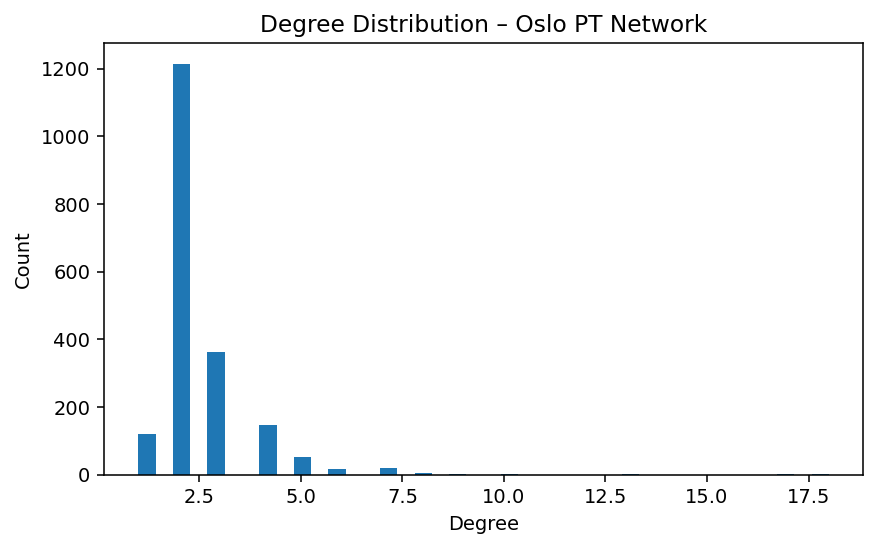

Clustering coefficient: 0.026344080083056352


In [4]:
# Undirected version for structural metrics
G_und = G.to_undirected()

n_nodes = G_und.number_of_nodes()
n_edges = G_und.number_of_edges()

# Connected components
components = list(nx.connected_components(G_und))
component_sizes = sorted((len(c) for c in components), reverse=True)

print("Number of connected components:", len(components))
print("Largest component size:", component_sizes[0])
print("Share of nodes in largest component:",
      component_sizes[0] / n_nodes)

# Show a few smallest components (possible broken fragments)
print("Smallest component sizes:", sorted(component_sizes)[:10])

# Degree distribution
degrees = [deg for _, deg in G_und.degree()]
avg_degree = sum(degrees) / len(degrees)
density = nx.density(G_und)

print("Average degree:", avg_degree)
print("Density:", density)

plt.hist(degrees, bins=40)
plt.title("Degree Distribution – Oslo PT Network")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Clustering coefficient
cc = nx.average_clustering(G_und)
print("Clustering coefficient:", cc)


# Step 4 – Spatial visualization

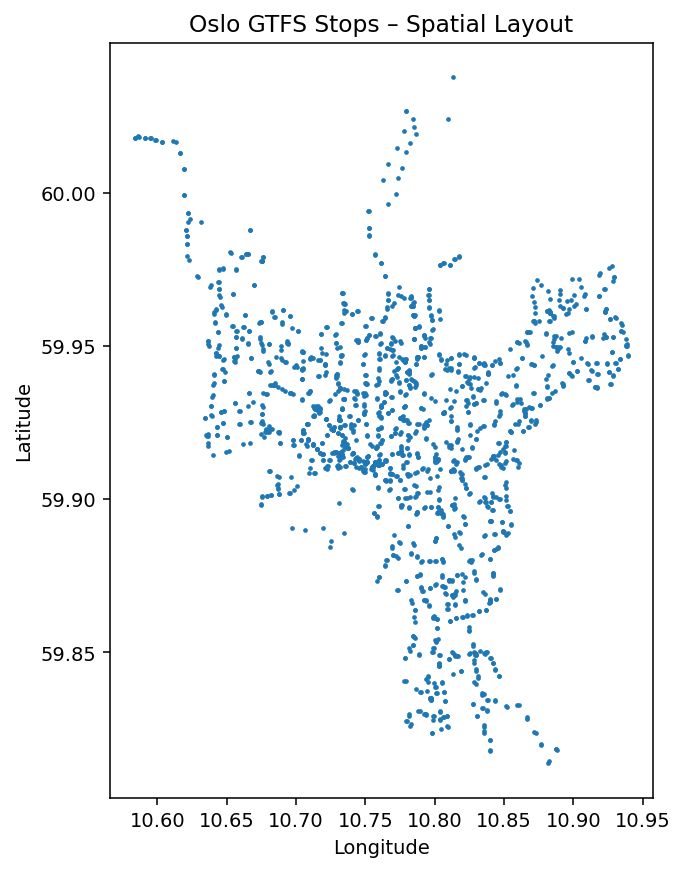

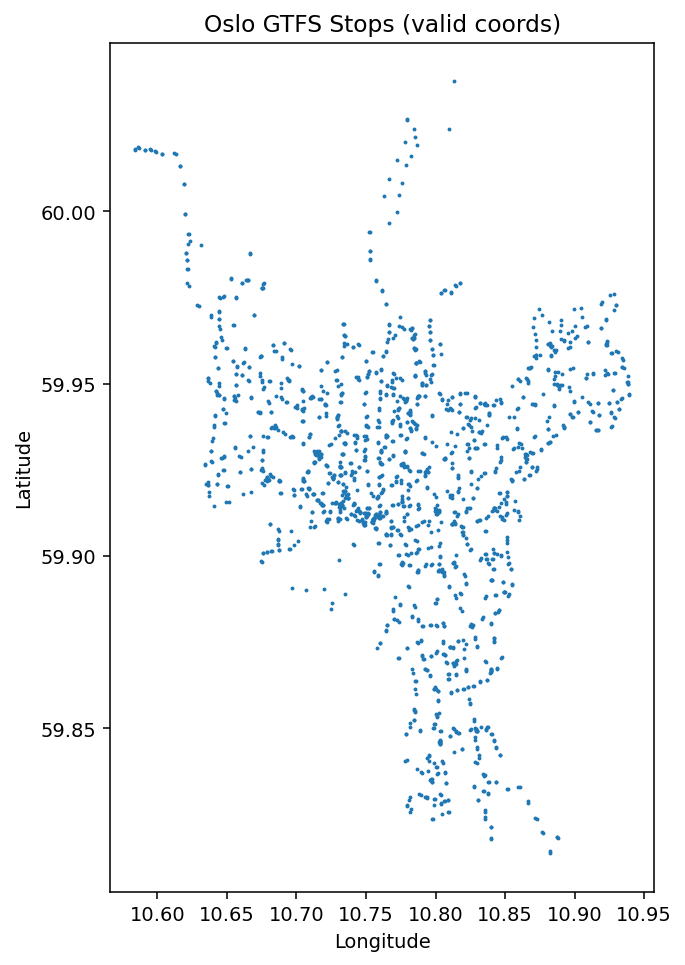

In [5]:
# Simple scatter of all stops
plt.figure(figsize=(5, 7))
plt.scatter(nodes[NODE_LON_COL], nodes[NODE_LAT_COL], s=2)
plt.title("Oslo GTFS Stops – Spatial Layout")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.ylabel("Latitude")
plt.show()

has_coords = nodes[NODE_LAT_COL].notna() & nodes[NODE_LON_COL].notna()
coords = nodes[has_coords]

plt.figure(figsize=(5, 7))
plt.scatter(coords[NODE_LON_COL], coords[NODE_LAT_COL], s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Oslo GTFS Stops (valid coords)")
plt.tight_layout()
plt.savefig("Oslo_stops_scatter.png")
plt.show()


# Step 5 - Summary printout

In [6]:
print("----- Network summary -----")
print("Nodes:", n_nodes)
print("Edges:", n_edges)
print("Isolated nodes:", len(isolated_nodes))
print("Orphan edges:", len(orphan_edges))
print("Edges with bad travel times:", len(bad_time))
print("Connected components:", len(components))
print("Largest component size:", component_sizes[0])
print("Share in largest component:", component_sizes[0] / n_nodes)
print("Average degree:", avg_degree)
print("Density:", density)
print("Clustering coefficient:", cc)


----- Network summary -----
Nodes: 1941
Edges: 2420
Isolated nodes: 0
Orphan edges: 0
Edges with bad travel times: 150
Connected components: 11
Largest component size: 1504
Share in largest component: 0.7748583204533745
Average degree: 2.493560020607934
Density: 0.0012853402168082134
Clustering coefficient: 0.026344080083056352
